# CS 639 Problem set 1-3: Fully-Connected Neural Networks (180 points)

Before we start, please put your name(s) and your UW NetID

1. Firstname1 LASTNAME1, NetID1   //   e.g.) Josef PIEPER, 0123456789
2. Firstname2 LASTNAME2, NetID2   //   e.g.) Mel GIBSON, 9876543210

**Your Answer:**   
1. Grant Ovsepyan,  ##########
2. Tiancheng Xiong, ##########

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a CS_639 folder and put all the files under PS1 folder, then 'CS_639/PS1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS_639/PS1'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['cs639', '__pycache__', 'ps1_helper.py', 'linear_classifier.py', 'fully_connected_networks.py', 'softmax_best_model.pt', 'best_two_layer_net.pth', 'best_overfit_five_layer_net.pth', 'knn.py', 'knn.ipynb', 'linear_classifier.ipynb', 'fully_connected_networks.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from fully_connected_networks.py!
Hello from ps1_helper.py!
```

as well as the last edit time for the file `fully_connected_networks.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Central"
time.tzset()

from fully_connected_networks import hello_fully_connected_networks
hello_fully_connected_networks()

from ps1_helper import hello_helper
hello_helper()

fully_connected_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'fully_connected_networks.py')
fully_connected_networks_edit_time = time.ctime(os.path.getmtime(fully_connected_networks_path))
print('fully_connected_networks.py last edited on %s' % fully_connected_networks_edit_time)


Hello from fully_connected_networks.py!
Hello from ps1_helper.py!
fully_connected_networks.py last edited on Thu Feb 23 20:18:19 2023


# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import cs639
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline
from cs639 import reset_seed, Solver


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load the CIFAR-10 dataset
Then, we will first load the CIFAR-10 dataset. The utility function `cs639.data.preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


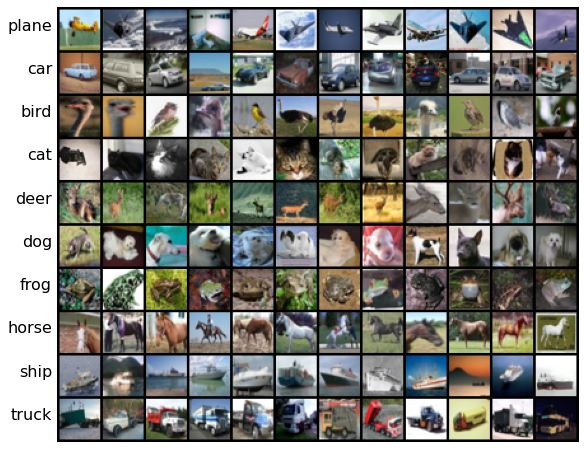

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [ ]:
# Invoke the above function to get our data. 
import cs639

cs639.reset_seed(0)
data_dict = cs639.data.preprocess_cifar10(cuda=True, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Fully-connected neural networks


In this exercise we will implement fully-connected networks using a modular approach. The goal of such an approach will be to build networks using a design so that we can implement different layer types in isolation and then snap them together into models with different architectures
For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.


To validate our implementation, we will compare the analytically computed gradients with numerical approximations of the gradient as done in previous assignments. You can inspect the numeric gradient function `compute_numeric_gradient` in `cs639/grad.py`. Please note that we have updated the function to accept upstream gradients to allow us to debug intermediate layers easily. You can check the update description by running the code block below.
  

In [ ]:
help(cs639.grad.compute_numeric_gradient)

Help on function compute_numeric_gradient in module cs639.grad:

compute_numeric_gradient(f, x, dLdf=None, h=1e-07)
    Compute the numeric gradient of f at x using a finite differences
    approximation. We use the centered difference:
    
    df    f(x + h) - f(x - h)
    -- ~= -------------------
    dx           2 * h
    
    Function can also expand this easily to intermediate layers using the
    chain rule:
    
    dL   df   dL
    -- = -- * --
    dx   dx   df
    
    Inputs:
    - f: A function that inputs a torch tensor and returns a torch scalar
    - x: A torch tensor giving the point at which to compute the gradient
    - dLdf: optional upstream gradient for intermediate layers
    - h: epsilon used in the finite difference calculation
    Returns:
    - grad: A tensor of the same shape as x giving the gradient of f at x



# Linear layer

For each layer we implement, we will define a class with two static methods `forward` and `backward`. The class structure is currently provided in `fully_connected_layers.py`, you will be implementing both the `forward` and `backward` methods.

## Linear layer: forward (20 points)
Implement the `Linear.forward` function in `fully_connected_layers.py`. Once you are done you can test your implementaion by running the next cell. You should see errors less than `1e-7`.

In [ ]:
from fully_connected_networks import Linear

# Test the Linear.forward function
num_inputs = 3
input_shape = torch.tensor((4, 4))
output_dim = 5

input_size = num_inputs * torch.prod(input_shape)
weight_size = output_dim * torch.prod(input_shape)

x = torch.linspace(-0.3, 0.3, steps=input_size, dtype=torch.float64, device='cuda')
w = torch.linspace(-0.2, 0.4, steps=weight_size, dtype=torch.float64, device='cuda')
b = torch.linspace(-0.1, 0.5, steps=output_dim, dtype=torch.float64, device='cuda')
x = x.reshape(num_inputs, *input_shape)
w = w.reshape(torch.prod(input_shape), output_dim)

out, _ = Linear.forward(x, w, b)
correct_out = torch.tensor([[-0.21234043, -0.08716133,  0.03801778,  0.16319688,  0.28837598],
                            [ 0.06482629,  0.21482629,  0.36482629,  0.51482629,  0.66482629],
                            [ 0.34199300,  0.51681390,  0.69163480,  0.86645570,  1.04127660]]
                            ).double().cuda()

print('Testing Linear.forward function:')
print('difference: ', cs639.grad.rel_error(out, correct_out))

Testing Linear.forward function:
difference:  1.0983413827076334e-08


## Linear layer: backward (30 points)
Now implement the `Linear.backward` function and test your implementation using numeric gradient checking. 

Run the following to test your implementation of `Linear.backward`. You should see errors less than `1e-7`.

In [ ]:
from fully_connected_networks import Linear

# Test the Linear.backward function
reset_seed(0)
x = torch.randn(5, 3, 4, dtype=torch.float64, device='cuda')
w = torch.randn(12, 7, dtype=torch.float64, device='cuda')
b = torch.randn(7, dtype=torch.float64, device='cuda')
dout = torch.randn(5, 7, dtype=torch.float64, device='cuda')

dx_num = cs639.grad.compute_numeric_gradient(lambda x: Linear.forward(x, w, b)[0], x, dout)
dw_num = cs639.grad.compute_numeric_gradient(lambda w: Linear.forward(x, w, b)[0], w, dout)
db_num = cs639.grad.compute_numeric_gradient(lambda b: Linear.forward(x, w, b)[0], b, dout)

_, cache = Linear.forward(x, w, b)
dx, dw, db = Linear.backward(dout, cache)

# The error should be around e-10 or less
print('Testing Linear.backward function:')
print('dx error: ', cs639.grad.rel_error(dx_num, dx))
print('dw error: ', cs639.grad.rel_error(dw_num, dw))
print('db error: ', cs639.grad.rel_error(db_num, db))

Testing Linear.backward function:
dx error:  1.1419680360487502e-09
dw error:  9.515673936710933e-10
db error:  4.802738779656281e-10


# ReLU activation

We will now implement the ReLU nonlinearity. As above, we will define a class with two empty static methods, and implement them in upcoming cells. The class structure can be found in `fully_connected_networks.py`

## ReLU activation: forward (10 points)
Implement the forward pass for the ReLU activation function in the `ReLU.forward` function. You **should not** change the input tensor with an in-place operation. 

Run the following to test your implementation of the ReLU forward pass. Your errors should be less than `1e-7`.

In [ ]:
from fully_connected_networks import ReLU

reset_seed(0)
x = torch.linspace(-1.0, 1.0, steps=15, dtype=torch.float64, device='cuda')
x = x.reshape(5, 3)

out, _ = ReLU.forward(x)
correct_out = torch.tensor([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
                            [0.00000000e+00, 5.55111512e-17, 1.42857143e-01],
                            [2.85714286e-01, 4.28571429e-01, 5.71428571e-01],
                            [7.14285714e-01, 8.57142857e-01, 1.00000000e+00]
                            ],
                            dtype=torch.float64,
                            device='cuda')

# Compare your output with ours. The error should be on the order of e-8
print('Testing ReLU.forward function:')
print('difference: ', cs639.grad.rel_error(out, correct_out))

Testing ReLU.forward function:
difference:  2.1428570029513594e-10


## ReLU activation: backward (10 points)
Now implement the backward pass for the ReLU activation function.

Again, you should not change the input tensor with an in-place operation.

Run the following to test your implementation of `ReLU.backward`. Your errors should be less than `1e-8`.

In [ ]:
from fully_connected_networks import ReLU

reset_seed(0)
x = torch.randn(5, 5, dtype=torch.float64, device='cuda')
dout = torch.randn(*x.shape, dtype=torch.float64, device='cuda')

dx_num = cs639.grad.compute_numeric_gradient(lambda x: ReLU.forward(x)[0], x, dout)

_, cache = ReLU.forward(x)
dx = ReLU.backward(dout, cache)

# The error should be on the order of e-12
print('Testing ReLU.backward function:')
print('dx error: ', cs639.grad.rel_error(dx_num, dx))

Testing ReLU.backward function:
dx error:  2.6317796097761553e-10


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, linear layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define a convenience layer.

This also shows how our layer abstraction allows us to implement new layers by composing existing layer implementations. This is a powerful mechanism for structuring deep learning code in a modular fashion.

For now take a look at the `forward` and `backward` functions in `Linear_ReLU`, and run the following to numerically gradient check the backward pass.

Run the following to test the implementation of the `Linear_ReLU` layer using numeric gradient checking. You should see errors less than `1e-8`

In [ ]:
from fully_connected_networks import Linear_ReLU

reset_seed(0)
x = torch.randn(5, 2, 3, dtype=torch.float64, device='cuda')
w = torch.randn(6, 8, dtype=torch.float64, device='cuda')
b = torch.randn(8, dtype=torch.float64, device='cuda')
dout = torch.randn(5, 8, dtype=torch.float64, device='cuda')

out, cache = Linear_ReLU.forward(x, w, b)
dx, dw, db = Linear_ReLU.backward(dout, cache)

dx_num = cs639.grad.compute_numeric_gradient(lambda x: Linear_ReLU.forward(x, w, b)[0], x, dout)
dw_num = cs639.grad.compute_numeric_gradient(lambda w: Linear_ReLU.forward(x, w, b)[0], w, dout)
db_num = cs639.grad.compute_numeric_gradient(lambda b: Linear_ReLU.forward(x, w, b)[0], b, dout)

# Relative error should be around e-8 or less
print('Testing Linear_ReLU.forward and Linear_ReLU.backward:')
print('dx error: ', cs639.grad.rel_error(dx_num, dx))
print('dw error: ', cs639.grad.rel_error(dw_num, dw))
print('db error: ', cs639.grad.rel_error(db_num, db))

Testing Linear_ReLU.forward and Linear_ReLU.backward:
dx error:  8.995643765443969e-10
dw error:  6.945416066707608e-10
db error:  3.6184721318142295e-10


# Loss layers: Softmax
You implemented the softmax loss functions in the last assignment, so we'll give it to you for free in `ps1_helper.py`. You should still make sure you understand how it works by looking at the implementations. We can first verify our implementation.


Run the following to perform numeric gradient checking on the two loss functions. You should see errors less than `1e-6` for softmax_loss.

In [ ]:
from ps1_helper import softmax_loss

reset_seed(0)
num_classes, num_inputs = 10, 10
x = 0.0005 * torch.randn(num_inputs, num_classes, dtype=torch.float64, device='cuda')
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device='cuda')

dx_num = cs639.grad.compute_numeric_gradient(lambda x: softmax_loss(x, y)[0], x)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss.item())
print('dx error: ', cs639.grad.rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.3024402902803405
dx error:  1.5984825190398843e-08


# Two-layer network (50 points)
You will implement the two layer network using modular implementations.

Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. 

Once you have finished implementing the forward and backward passes of your two-layer net, run the following to test your implementation:

In [ ]:
from fully_connected_networks import TwoLayerNet
from ps1_helper import softmax_loss

reset_seed(0)
N, D, H, C = 5, 10, 20, 4
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

std = 1e-3
model = TwoLayerNet(
          input_dim=D,
          hidden_dim=H,
          num_classes=C,
          weight_scale=std,
          dtype=torch.float64,
          device='cuda'
        )

print('Testing initialization ... ')
W1_std = torch.abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = torch.abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert torch.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert torch.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = torch.linspace(-0.2, 0.2, steps=D * H, dtype=torch.float64, device='cuda').reshape(D, H)
model.params['b1'] = torch.linspace(-0.3, 0.3, steps=H, dtype=torch.float64, device='cuda')
model.params['W2'] = torch.linspace(-0.4, 0.4, steps=H * C, dtype=torch.float64, device='cuda').reshape(H, C)
model.params['b2'] = torch.linspace(-0.7, 0.7, steps=C, dtype=torch.float64, device='cuda')
X = torch.linspace(-0.5, 7.7, steps=N * D, dtype=torch.float64, device='cuda').reshape(D, N).t()
scores = model.loss(X)

correct_scores = torch.tensor(
  [[1.07553643, 2.10424866, 3.13296090, 4.16167313],
   [1.16614498, 2.19485722, 3.22356945, 4.25228169],
   [1.25675354, 2.28546578, 3.31417801, 4.34289025],
   [1.34736210, 2.37607434, 3.40478657, 4.43349880],
   [1.43797066, 2.46668289, 3.49539513, 4.52410736]],
    dtype=torch.float64, device='cuda')
scores_diff = torch.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = torch.tensor([0, 0, 1, 2, 3])
loss, grads = model.loss(X, y)
torch.set_printoptions(precision=10)

correct_loss = 2.2775559358
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 4.0
loss, grads = model.loss(X, y)
correct_loss = 30.5501594598
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-6 or less
for reg in [0.0, 1.0]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = cs639.grad.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, cs639.grad.rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 2.57e-08
W2 relative error: 1.33e-09
b1 relative error: 1.43e-07
b2 relative error: 2.87e-09
Running numeric gradient check with reg =  1.0
W1 relative error: 1.37e-08
W2 relative error: 2.45e-09
b1 relative error: 1.91e-07
b2 relative error: 6.58e-09


# Solver (20 points)
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Read through `help(Solver)` to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [ ]:
print(help(Solver))

Help on class Solver in module cs639.utils:

class Solver(builtins.object)
 |  Solver(model, data, **kwargs)
 |  
 |  A Solver encapsulates all the logic necessary for training classification
 |  models. The Solver performs stochastic gradient descent using different
 |  update rules.
 |  The solver accepts both training and validation data and labels so it can
 |  periodically check classification accuracy on both training and validation
 |  data to watch out for overfitting.
 |  To train a model, you will first construct a Solver instance, passing the
 |  model, dataset, and various options (learning rate, batch size, etc) to the
 |  constructor. You will then call the train() method to run the optimization
 |  procedure and train the model.
 |  After the train() method returns, model.params will contain the parameters
 |  that performed best on the validation set over the course of training.
 |  In addition, the instance variable solver.loss_history will contain a list
 |  of all lo

Use the Solver classe to create a solver instance that trains a TwoLayerNet to achieve at least 50% performance on the validation set. 

**Implement** `create_solver_instance` in `fully_connected_networks.py` to return a solver instance. Make sure to initialize the Solver instance with the input device.

In [ ]:
from fully_connected_networks import create_solver_instance

reset_seed(0)

# Create a solver instance that achieves 50% performance on the validation set
solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device='cuda')
solver.train()


(Time 0.01 sec; Iteration 1 / 4000) loss: 2.302603
(Epoch 0 / 10) train acc: 0.096000; val_acc: 0.092200
(Time 0.28 sec; Iteration 11 / 4000) loss: 2.302131
(Time 0.33 sec; Iteration 21 / 4000) loss: 2.301974
(Time 0.37 sec; Iteration 31 / 4000) loss: 2.302352
(Time 0.42 sec; Iteration 41 / 4000) loss: 2.297661
(Time 0.47 sec; Iteration 51 / 4000) loss: 2.283626
(Time 0.52 sec; Iteration 61 / 4000) loss: 2.268614
(Time 0.56 sec; Iteration 71 / 4000) loss: 2.212975
(Time 0.61 sec; Iteration 81 / 4000) loss: 2.185241
(Time 0.65 sec; Iteration 91 / 4000) loss: 2.173307
(Time 0.70 sec; Iteration 101 / 4000) loss: 2.183683
(Time 0.75 sec; Iteration 111 / 4000) loss: 2.091396
(Time 0.79 sec; Iteration 121 / 4000) loss: 2.059497
(Time 0.84 sec; Iteration 131 / 4000) loss: 2.073542
(Time 0.89 sec; Iteration 141 / 4000) loss: 2.043060
(Time 0.93 sec; Iteration 151 / 4000) loss: 2.057305
(Time 0.98 sec; Iteration 161 / 4000) loss: 2.060444
(Time 1.02 sec; Iteration 171 / 4000) loss: 1.969404
(Ti

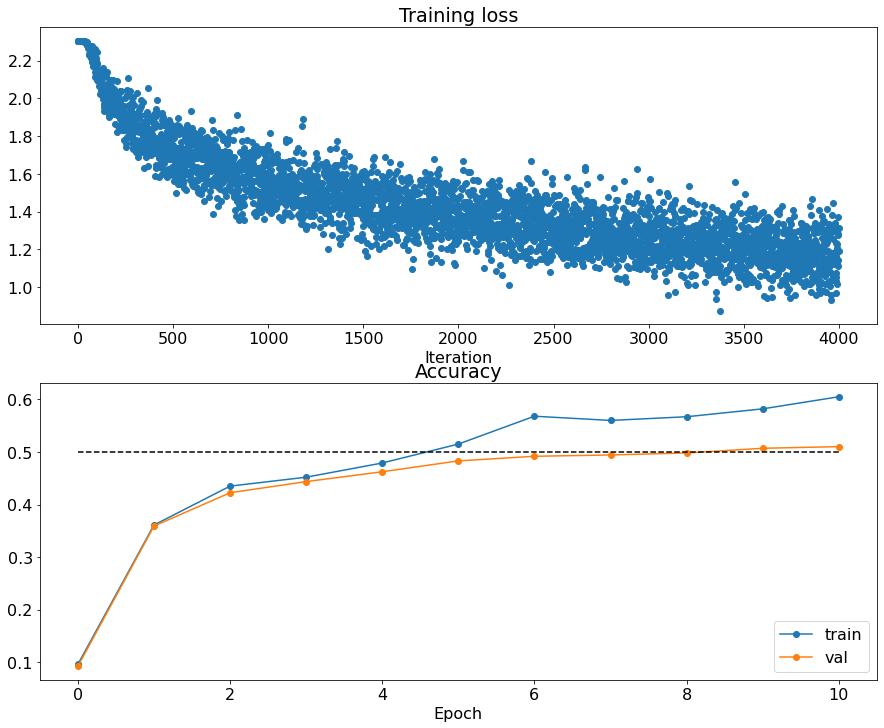

In [ ]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

If you're happy with the model's perfromance, run the following cell to save it. 

We will also reload the model and run it on validation to verify it's the right weights.

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH, 'best_two_layer_net.pth')
solver.model.save(path)

# Create a new instance
from fully_connected_networks import create_solver_instance
reset_seed(0)

solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device='cuda')

# Load model
solver.model.load(path, dtype=torch.float64, device='cuda')

# Evaluate on validation set
accuracy = solver.check_accuracy(solver.X_val, solver.y_val)
print(f"Saved model's accuracy on validation is {accuracy}")


Saved in drive/My Drive/CS_639/PS1/best_two_layer_net.pth
load checkpoint file: drive/My Drive/CS_639/PS1/best_two_layer_net.pth
Saved model's accuracy on validation is 0.5101000070571899


# Multilayer network (40 points)
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in `fully_connected_networks.py`. Implement the initialization, the forward pass, and the backward pass. 

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors less than `1e-6`, except for the check on `W1` and `W2` with `reg=0` where your errors should be less than `1e-5`.

In [ ]:
from fully_connected_networks import FullyConnectedNet

reset_seed(0)
N, D, H1, H2, C = 3, 10, 25, 15, 10
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

for reg in [0, 2.78]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet(
        [H1, H2], 
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2, 
        dtype=torch.float64, 
        device='cuda'
  )

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = cs639.grad.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, cs639.grad.rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.302874490398591
W1 relative error: 1.96e-07
W2 relative error: 2.75e-07
W3 relative error: 8.31e-08
b1 relative error: 2.36e-07
b2 relative error: 3.24e-08
b3 relative error: 5.57e-09
Running check with reg =  2.78
Initial loss:  5.090831145268905
W1 relative error: 6.73e-09
W2 relative error: 6.95e-09
W3 relative error: 8.68e-09
b1 relative error: 2.84e-07
b2 relative error: 3.20e-08
b3 relative error: 5.85e-09


As another sanity check, make sure you can overfit a small dataset of 100 images. First we will try a three-layer network with 50 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 25 epochs.

(Time 0.02 sec; Iteration 1 / 100) loss: 409.389862
(Epoch 0 / 25) train acc: 0.120000; val_acc: 0.097500
(Epoch 1 / 25) train acc: 0.180000; val_acc: 0.106600
(Epoch 2 / 25) train acc: 0.430000; val_acc: 0.118900
(Time 0.12 sec; Iteration 11 / 100) loss: 66.625710
(Epoch 3 / 25) train acc: 0.530000; val_acc: 0.118600
(Epoch 4 / 25) train acc: 0.610000; val_acc: 0.121900
(Epoch 5 / 25) train acc: 0.670000; val_acc: 0.120300
(Time 0.23 sec; Iteration 21 / 100) loss: 15.154138
(Epoch 6 / 25) train acc: 0.810000; val_acc: 0.121600
(Epoch 7 / 25) train acc: 0.840000; val_acc: 0.125200
(Time 0.32 sec; Iteration 31 / 100) loss: 1.952752
(Epoch 8 / 25) train acc: 0.830000; val_acc: 0.124000
(Epoch 9 / 25) train acc: 0.890000; val_acc: 0.126600
(Epoch 10 / 25) train acc: 0.950000; val_acc: 0.123200
(Time 0.41 sec; Iteration 41 / 100) loss: 1.420045
(Epoch 11 / 25) train acc: 0.960000; val_acc: 0.124500
(Epoch 12 / 25) train acc: 0.960000; val_acc: 0.124600
(Time 0.49 sec; Iteration 51 / 100) l

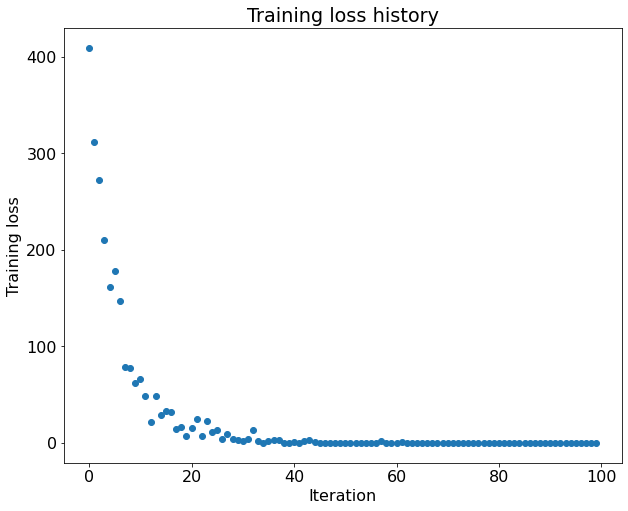

In [ ]:
from fully_connected_networks import FullyConnectedNet, get_three_layer_network_params

# TODO: Use a three-layer Net to overfit 100 training examples by 
# tweaking just the learning rate and initialization scale.
reset_seed(0)

num_train = 100
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_three_layer_network_params()

model = FullyConnectedNet([50, 50],
              weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=25, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 50 units on each layer to overfit 100 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 40 epochs.

(Time 0.00 sec; Iteration 1 / 160) loss: 381.754669
(Epoch 0 / 40) train acc: 0.160000; val_acc: 0.122300
(Epoch 1 / 40) train acc: 0.200000; val_acc: 0.099100
(Epoch 2 / 40) train acc: 0.340000; val_acc: 0.113200
(Time 0.15 sec; Iteration 11 / 160) loss: 8.618773
(Epoch 3 / 40) train acc: 0.510000; val_acc: 0.126900
(Epoch 4 / 40) train acc: 0.630000; val_acc: 0.124900
(Epoch 5 / 40) train acc: 0.680000; val_acc: 0.121100
(Time 0.31 sec; Iteration 21 / 160) loss: 2.665493
(Epoch 6 / 40) train acc: 0.780000; val_acc: 0.121200
(Epoch 7 / 40) train acc: 0.820000; val_acc: 0.123900
(Time 0.41 sec; Iteration 31 / 160) loss: 0.189860
(Epoch 8 / 40) train acc: 0.890000; val_acc: 0.123800
(Epoch 9 / 40) train acc: 0.920000; val_acc: 0.125600
(Epoch 10 / 40) train acc: 0.960000; val_acc: 0.128100
(Time 0.58 sec; Iteration 41 / 160) loss: 0.053355
(Epoch 11 / 40) train acc: 0.980000; val_acc: 0.130200
(Epoch 12 / 40) train acc: 0.970000; val_acc: 0.128200
(Time 0.70 sec; Iteration 51 / 160) los

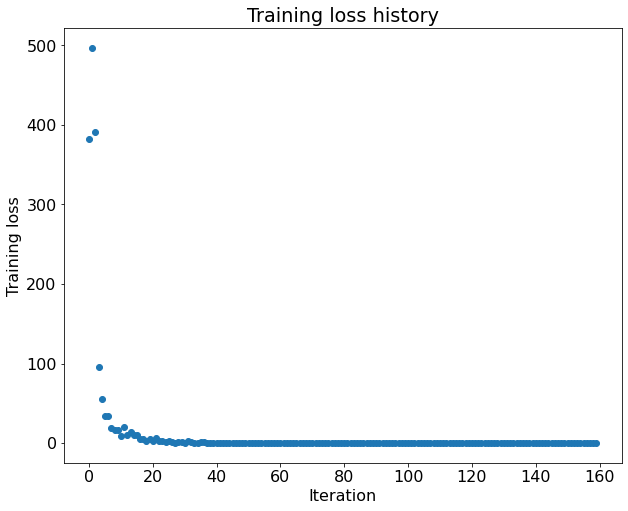

In [ ]:
from fully_connected_networks import FullyConnectedNet, get_five_layer_network_params

# TODO: Use a five-layer Net to overfit 100 training examples by 
# tweaking just the learning rate and initialization scale.
reset_seed(0)

num_train = 100
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}


# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_five_layer_network_params()

# Run models and solver with parameters
model = FullyConnectedNet([50, 50, 50, 50],
                weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=40, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

If you're satisfied with your model's performance, save the overfit model. Just a sanity check, we evaluate it one the training set again to verify that the saved weights have the correct performance. 

In [ ]:
# Set path 
path = os.path.join(GOOGLE_DRIVE_PATH, 'best_overfit_five_layer_net.pth')
solver.model.save(path)


# Create a new instance  -- Note that hidden dims being different doesn't matter here.
model = FullyConnectedNet(hidden_dims=[100, ], dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )


# Load model
solver.model.load(path, dtype=torch.float32, device='cuda')

# Evaluate on validation set
accuracy = solver.check_accuracy(solver.X_train, solver.y_train)
print(f"Saved model's accuracy on small train is {accuracy}")


Saved in drive/My Drive/CS_639/PS1/best_overfit_five_layer_net.pth
load checkpoint file: drive/My Drive/CS_639/PS1/best_overfit_five_layer_net.pth
Saved model's accuracy on small train is 1.0


## Submit Your Work
After completing this notebook, run the following cell to create a `.zip` file for you to download and turn in. **Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from cs639.submit import make_ps1_submission

make_ps1_submission(GOOGLE_DRIVE_PATH)

Enter firstname1_firstname2 as your uniquename (e.g., Josef Pieper and Mel Gibson -> joseph_mel): tiancheng_ben
Writing zip file to:  drive/My Drive/CS_639/PS1/tiancheng_ben_PS1.zip
